In [1]:
from typing import List

import chess
import pandas as pd
import numpy as np
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical
from reconchess import Turn
from tensorflow.python.keras import Input
from tensorflow.python.keras.layers import Conv2D, Activation, Dropout, LSTM, Dense
from tensorflow.python.keras.models import Model

from game_log_reader.game_history_extended import GameHistoryExtended

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\pydot.py:17: UserWarning: `pydot` could not import `dot_parser`, so `pydot` will be unable to parse DOT files. The error was:  No module named 'pyparsing'
  warnings.warn(


In [2]:
history = GameHistoryExtended.from_file('game_logs/historical_games_extended/571698.json')
color = chess.WHITE
move = 1

In [3]:
def int_to_square(squares):
    board = np.zeros(64)
    if squares is not None:
        board[squares] = 1
    return board.reshape((8, 8))

In [4]:
def parse_position(board, color):
    return [np.reshape([board.pieces_mask(piece_type, color) >> i & 1 for i in range(64)], (8, 8)) for piece_type in
            chess.PIECE_TYPES]

In [45]:
def map_move(history: GameHistoryExtended, turn: Turn):
    color = turn.color
    move = turn.turn_number

    # 1 Color Layer
    color_layer = np.ones((1, 8, 8)) if color else np.zeros((1, 8, 8))
    # 1 Sense Location Layer
    sense_location = np.array([int_to_square(history.sense(turn))])
    # 6 Sense Result Layers - one for each piece type
    sense_res = np.array([
        int_to_square([
            result[0] for result in history.sense_result(turn) if
            (result[1] is not None and result[1].piece_type == piece_type)
        ]) for piece_type in chess.PIECE_TYPES
    ])
    # 1 Layer for piece captured on previous turn
    opponent_capture_square = np.zeros((1, 8, 8)) if turn == Turn(chess.WHITE, 0) else \
        np.array([int_to_square(history.capture_square(turn.previous))])

    # 6 Layers for current state of owned pieces
    owned_piece_positions = np.array([
        np.reshape([history.truth_board_before_move(turn).pieces_mask(piece_type, color) >> i & 1 for i in range(64)],
                   (8, 8))
        for piece_type in chess.PIECE_TYPES
    ])

    # 6 Layers for last move origin - one for each piece type
    last_move_origin = np.zeros((6, 8, 8))

    # 1 Layer for last move requested destination
    last_move_requested_destination = np.zeros((1, 8, 8))

    # 3 Layers for successful under-promotions
    under_promotions = np.zeros((3, 8, 8))

    # 1 Layer for last move taken destination
    last_move_taken_destination = np.zeros((1, 8, 8))

    # 1 Layer for captured piece
    captured_square = np.zeros((1, 8, 8))

    if move > 0:
        prev_turn = turn.previous.previous
        requested_move = history.requested_move(prev_turn)
        if requested_move is not None:
            piece_type = history.truth_board_before_move(prev_turn).piece_at(requested_move.from_square).piece_type
            last_move_origin[chess.PIECE_TYPES.index(piece_type)] = int_to_square(requested_move.from_square)
            last_move_requested_destination = np.array([int_to_square(requested_move.to_square)])

        if history.capture_square(prev_turn) is not None:
            captured_square = [int_to_square(history.capture_square(prev_turn))]
        taken_move = history.taken_move(prev_turn)
        if taken_move is not None:
            last_move_taken_destination = np.array([int_to_square(taken_move.to_square)])

            if taken_move.promotion not in [None, chess.QUEEN]:
                under_promotions[[chess.ROOK, chess.KNIGHT, chess.BISHOP].index(taken_move.promotion)] = np.ones((8, 8))

    return np.concatenate(
        (color_layer,  # 0
         sense_location,  # 1
         sense_res, # 2-7
         opponent_capture_square, # 8
         last_move_origin, # 9-14
         last_move_requested_destination, # 15
         last_move_taken_destination, # 16
         captured_square, # 17
         under_promotions, # 18-20
         owned_piece_positions # 21-26
         )
    )

In [48]:
def map_game(history: GameHistoryExtended, color: chess.Color):
    if history._post_sense_uncertainty[not color] is None:
        return None

    measured_turns = len(history._post_sense_uncertainty[not color]) - int(not color)

    turns = [Turn(color, move) for move in range(measured_turns)]

    X = np.array([map_move(history, turn) for turn in turns])
    y = np.array(history._post_sense_uncertainty[not color][int(not color):])

    return X, y

In [49]:
map_game(history, chess.WHITE)

KeyboardInterrupt: 

In [ ]:
def cnn_lstm(input_dim, output_dim, dropout=0.2, n_layers=1):

    # Input data type
    dtype = 'float32'

    # ---- Network model ----
    input_data = Input(name='the_input', shape=input_dim, dtype=dtype)

    # 1 x 1D convolutional layers with strides 4
    x = Conv2D(filters=256, kernel_size=10, strides=4, name='conv_1')(input_data)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout, name='dropout_1')(x)

    x = LSTM(128, activation='relu', return_sequences=True,
             dropout=dropout, name='lstm_1')(x)
    x = LSTM(128, activation='relu', return_sequences=False,
             dropout=dropout, name='lstm_2')(x)

    x = Dense(units=64, activation='relu', name='fc')(x)
    x = Dropout(dropout, name='dropout_2')(x)

    # Output layer with softmax
    y_pred = Dense(units=output_dim, activation='softmax', name='softmax')(x)

    network_model = Model(inputs=input_data, outputs=y_pred)

    return network_model

In [22]:


result = np.ones((1, 8, 8)) if color else np.zeros((1, 8, 8))
# 1 Sense Location Layer
sense_loc = [int_to_square(history.sense(Turn(True, 1)))]

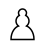

In [49]:
history.truth_board_before_move(Turn(True, 1)).piece_at(history.requested_move(Turn(True, 1)).from_square)

In [ ]:
np.stack((result, sense_loc), axis=1)

In [46]:
parse_position(history.truth_board_before_move(Turn(True, 0)), True)

[array([[0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        